# Predicting Negative Comments
This notebook outlines the process of predicting which users are likely to give negative comments using machine learning techniques.

## Load Necessary Libraries
First, we'll import all the necessary libraries for data handling, visualization, and machine learning.

In [2]:
# Basic Libraries
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import squarify  # Treemap plotting library
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier


# Download necessary NLTK data

sb.set() # set the default Seaborn style for graphics

# Loading the database

In [3]:
data = pd.read_csv('sentiment-emotion.csv')
data.head()
# Display basic information and the first few rows of the dataset
data_info = data.info()
first_rows = data.head()

data_info, first_rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24970 entries, 0 to 24969
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       24970 non-null  int64  
 1   Datetime         24970 non-null  object 
 2   Tweet Id         24970 non-null  float64
 3   Text             24970 non-null  object 
 4   Username         24970 non-null  object 
 5   sentiment        24970 non-null  object 
 6   sentiment_score  24970 non-null  float64
 7   emotion          24970 non-null  object 
 8   emotion_score    24970 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


(None,
    Unnamed: 0                   Datetime      Tweet Id  \
 0           0  2022-09-30 23:29:15+00:00  1.575990e+18   
 1           1  2022-09-30 21:46:35+00:00  1.575970e+18   
 2           2  2022-09-30 21:18:02+00:00  1.575960e+18   
 3           3  2022-09-30 20:05:24+00:00  1.575940e+18   
 4           4  2022-09-30 20:03:17+00:00  1.575940e+18   
 
                                                 Text        Username  \
 0  @Logitech @apple @Google @Microsoft @Dell @Len...  ManjuSreedaran   
 1  @MK_habit_addict @official_stier @MortalKombat...      MiKeMcDnet   
 2  As @CRN celebrates its 40th anniversary, Bob F...        jfollett   
 3  @dell your customer service is horrible especi...       daveccarr   
 4  @zacokalo @Dell @DellCares @Dell give the man ...      heycamella   
 
   sentiment  sentiment_score       emotion  emotion_score  
 0   neutral         0.853283  anticipation       0.587121  
 1   neutral         0.519470           joy       0.886913  
 2  positive  

# Filter the data base on sentiment 

First find the unique sentiment 


In [4]:
# Filter the dataset for negative comments
negative_comments = data[data['sentiment'] == 'negative']

# Overview of negative comments
negative_comments_overview = negative_comments.describe(include='all')

# Check the number of unique users in negative comments
unique_users_negative = negative_comments['Username'].nunique()

negative_comments_overview, unique_users_negative


(          Unnamed: 0                   Datetime      Tweet Id  \
 count   10556.000000                      10556  1.055600e+04   
 unique           NaN                      10517           NaN   
 top              NaN  2022-05-27 19:38:49+00:00           NaN   
 freq             NaN                          4           NaN   
 mean    12586.711823                        NaN  1.525998e+18   
 std      7484.678344                        NaN  2.877642e+16   
 min         3.000000                        NaN  1.477100e+18   
 25%      5984.750000                        NaN  1.500215e+18   
 50%     12228.000000                        NaN  1.526115e+18   
 75%     19550.250000                        NaN  1.550850e+18   
 max     24965.000000                        NaN  1.575940e+18   
 
                                                      Text        Username  \
 count                                               10556           10556   
 unique                                           

## The dataset contains 10,556 negative comments, made by 7,084 unique users. Here are some insights from the negative comments:

# A visual respentation 

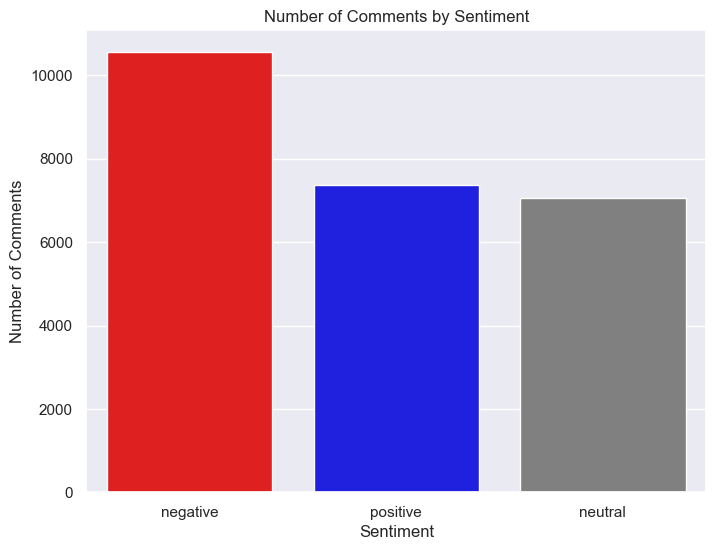

sentiment
negative    10556
positive     7366
neutral      7048
Name: count, dtype: int64

In [4]:
# It seems there was an issue with the previous code. Let's correct it and proceed with the visualization.

# Count the number of comments for each sentiment category
sentiment_counts = data['sentiment'].value_counts()

# Plot the counts of comments for each sentiment category
plt.figure(figsize=(8, 6))
sb.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'blue', 'grey'])
plt.title('Number of Comments by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

sentiment_counts


# The sentiment base on time of day
To see if there is we can use the time of day to determine the sentiment of the tweet

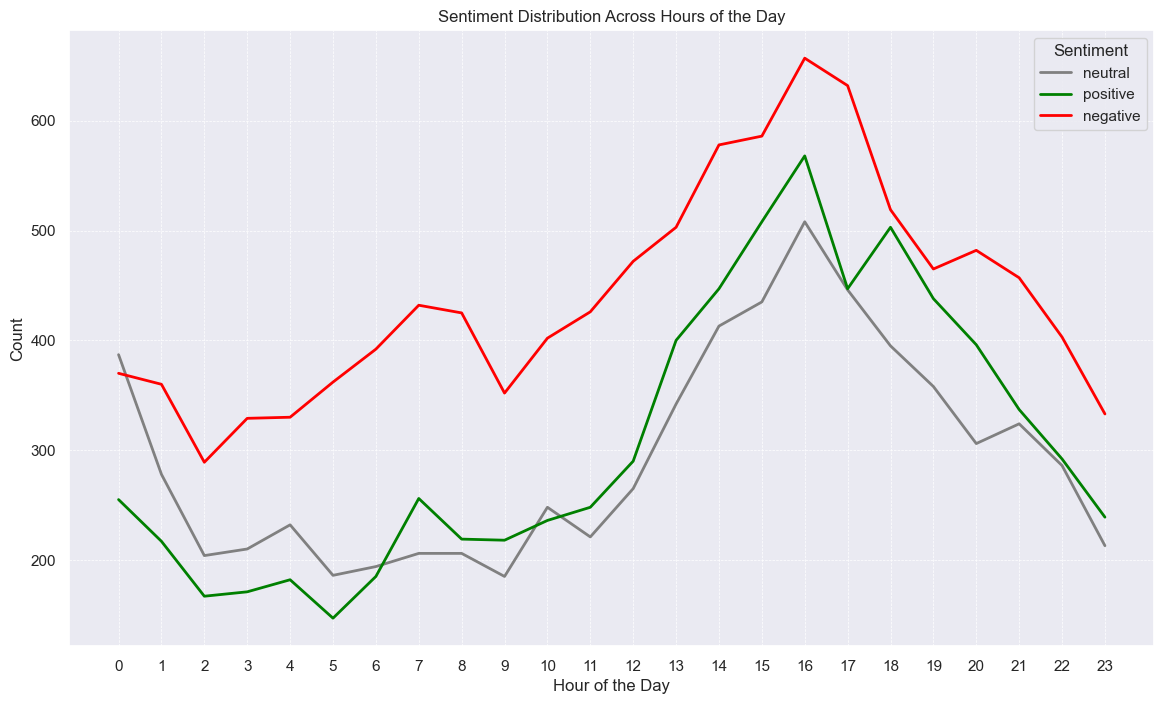

In [5]:
# Let's create line plots for each sentiment type to visualize their distribution across different hours of the day more distinctly.

plt.figure(figsize=(14, 8))
# Convert 'Datetime' column to datetime type
data['Datetime'] = pd.to_datetime(data['Datetime'])
color_map = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}

# Extract the hour from the 'Datetime' column
data['Hour'] = data['Datetime'].dt.hour
# Plotting each sentiment type with a line plot.
for sentiment in data['sentiment'].unique():
    subset = data[data['sentiment'] == sentiment]
    # Group by hour and count occurrences, then plot
    subset.groupby('Hour').size().plot(label=sentiment, linewidth=2, color=color_map[sentiment])

plt.title('Sentiment Distribution Across Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


# Treemap on Negative emotions
Checking on what are the most common negative emotions

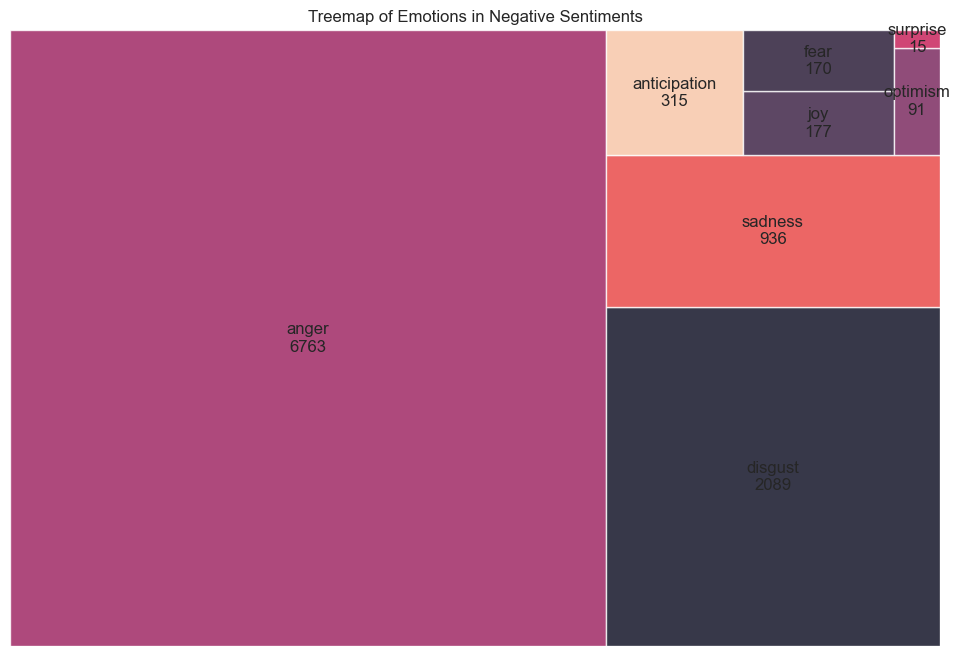

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # Treemap plotting library

# Sample data to mimic the user's scenario

# Filter for negative sentiments
negative_sentiments = data[data['sentiment'] == 'negative']

# Count the frequency of each emotion within negative sentiments
emotion_counts = negative_sentiments['emotion'].value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Create the treemap with numbers included
plt.figure(figsize=(12, 8))
squarify.plot(sizes=emotion_counts['Count'], label=emotion_counts['Emotion'] + '\n' + emotion_counts['Count'].astype(str), alpha=0.8)
plt.axis('off')  # Remove the axes for a cleaner look
plt.title('Treemap of Emotions in Negative Sentiments')

plt.show()


# Length of Text for both sentiment
if we can use the length of text to determine the sentiment of the text

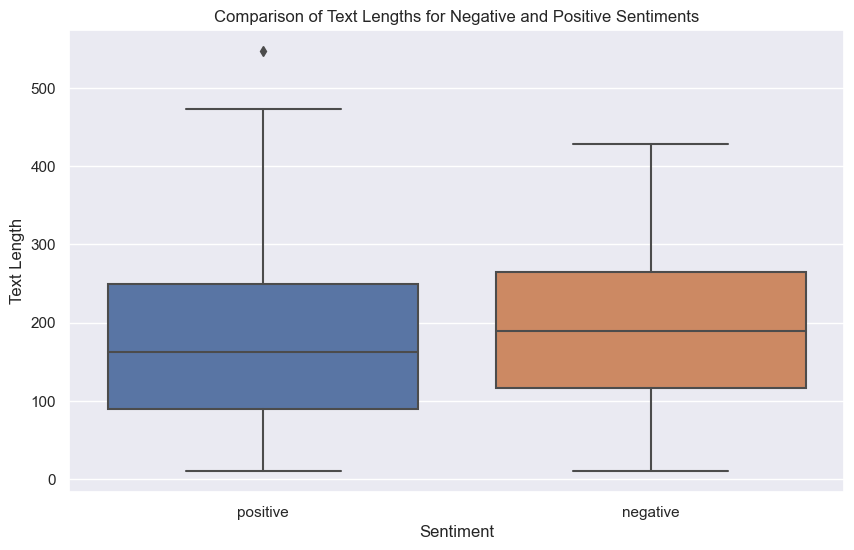

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

data['Text Length'] = data['Text'].apply(len)

# Filter the data for negative and positive sentiments
filtered_data = data[data['sentiment'].isin(['negative', 'positive'])]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='Text Length', data=filtered_data)
plt.title('Comparison of Text Lengths for Negative and Positive Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

## N-gram analysis
To find commonly used pair of words

In [5]:
# Re-importing NLTK components and redefining necessary functions
from nltk.tokenize import word_tokenize
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import re

# Ensure necessary NLTK resources are available
#nltk.download('punkt')
#nltk.download('stopwords')

# Redefining the enhanced text preprocessing function
def preprocess_text_enhanced(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove Twitter handles
    text = re.sub(r'@\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize text
    word_tokens = word_tokenize(text)
    # Define stopwords
    stop_words = set(stopwords.words('english'))
    # Remove stopwords and non-alphabetic words
    filtered_words = [word for word in word_tokens if word.isalpha() and word not in stop_words]
    return filtered_words

# Apply the enhanced preprocessing to each text entry in the simulated dataset
data['Processed_Text'] = data['Text'].apply(preprocess_text_enhanced)

# Re-run the bi-grams generation and counting for the entire dataset, by sentiment
bi_grams_by_sentiment = {}

for sentiment in data['sentiment'].unique():
    # Filter texts by sentiment
    sentiment_texts = data[data['sentiment'] == sentiment]['Processed_Text']
    # Flatten list of lists and generate bi-grams
    sentiment_bi_grams = [bg for text in sentiment_texts for bg in list(bigrams(text)) if len(text) >= 2]
    # Count frequencies
    bi_grams_by_sentiment[sentiment] = FreqDist(sentiment_bi_grams).most_common(5)

# Building a list of dictionaries for creating the DataFrame
rows = []
for sentiment, bi_grams in bi_grams_by_sentiment.items():
    for bi_gram, freq in bi_grams:
        rows.append({'Sentiment': sentiment, 'Bi-gram': ' '.join(bi_gram), 'Frequency': freq})

# Creating the DataFrame from the list of dictionaries
bi_grams_df_corrected = pd.DataFrame(rows)

# Display the corrected and formatted results
bi_grams_df_corrected




,Sentiment,Bi-gram,Frequency
0,neutral,et streaming,70
1,neutral,sat amp,65
2,neutral,amp sun,64
3,neutral,every sat,60
4,neutral,tv every,58
5,positive,dell technologies,104
6,positive,join us,71
7,positive,looking forward,61
8,positive,xps plus,60
9,positive,dell xps,57


# Predict whether a  user will continue giving negative text using Multinomial Naive Bayes

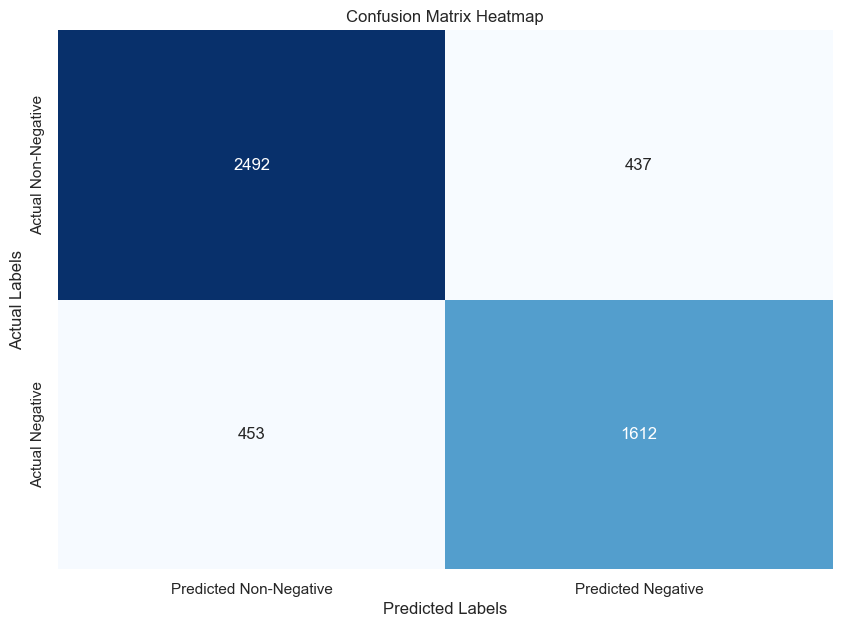

,precision,recall,f1-score,support
Non-Negative,0.85,0.85,0.85,2929.00
Negative,0.79,0.78,0.78,2065.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.82,0.82,0.82,4994.00
weighted avg,0.82,0.82,0.82,4994.00


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

import re

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

data['Text'] = data['Text'].apply(preprocess_text)

# Convert sentiment to binary labels
data['Label'] = (data['sentiment'] == 'negative').astype(int)

# Split data into features and labels
X = data['Text']
y = data['Label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model Training using Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Model Evaluation
predictions = model.predict(X_test_tfidf)

report = classification_report(y_test, predictions, target_names=['Non-Negative', 'Negative'], output_dict=True)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Negative', 'Actual Negative'], columns=['Predicted Non-Negative', 'Predicted Negative'])

# Adjusting labels for clarity in the sentiment analysis context

# Heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Summary Report as DataFrame
report_df = pd.DataFrame(report).transpose().round(2)

report_df

## Sequential Neural Network Model using Keras

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6930 - loss: 0.5732 - val_accuracy: 0.8363 - val_loss: 0.3624
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8642 - loss: 0.3164 - val_accuracy: 0.8581 - val_loss: 0.3190
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9070 - loss: 0.2341 - val_accuracy: 0.8644 - val_loss: 0.3040
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9304 - loss: 0.1892 - val_accuracy: 0.8661 - val_loss: 0.3023
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9488 - loss: 0.1545 - val_accuracy: 0.8661 - val_loss: 0.3120
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9604 - loss: 0.1248 - val_accuracy: 0.8569 - val_loss: 0.3323
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1047 - val_accuracy: 0.8604 - val_loss: 0.3470
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.8663 - loss: 0.3327
157/157 ━━━━━━━━━━━━

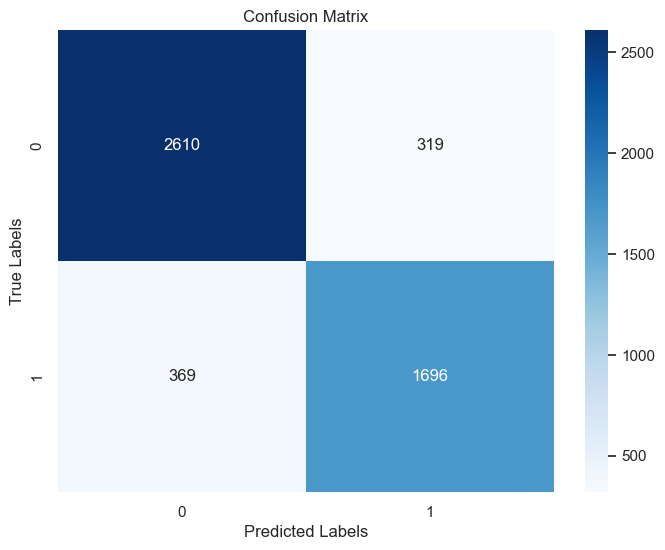

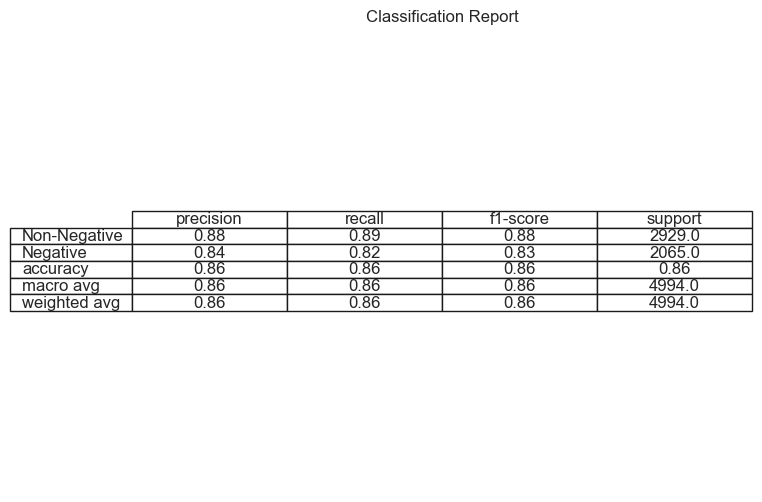

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Assuming 'Text' column for text and 'sentiment' column for labels in a DataFrame 'data'
# Make sure to replace 'data' with your actual DataFrame variable
texts = data['Text'].astype(str)
labels = (data['sentiment'] == 'negative').astype(int)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input size
maxlen = 100  # Maximum length of a sequence
X = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to categorical (one-hot encoding)
y = to_categorical(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
model = Sequential()
model.add(Embedding(10000, 8))  # Embedding layer for text input, input_length inferred
model.add(Flatten())  # Flatten the 3D tensor to 2D
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model's performance on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Predict the probabilities for each class
probabilities = model.predict(X_test)

# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# True labels (convert one-hot encoded y_test back to class labels if necessary)
true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Calculate classification report
report = classification_report(true_labels, predictions, target_names=['Non-Negative', 'Negative'], output_dict=True)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

# Prepare the data for the classification report
report_df = pd.DataFrame(report).transpose().round(2)

# Plotting the classification report as a table
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.table(cellText=report_df.values, colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc = 'center')
ax.set_title('Classification Report')
plt.show()

## Linear SVC Classifier

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2929
           1       0.81      0.74      0.77      2065

    accuracy                           0.82      4994
   macro avg       0.82      0.81      0.81      4994
weighted avg       0.82      0.82      0.82      4994



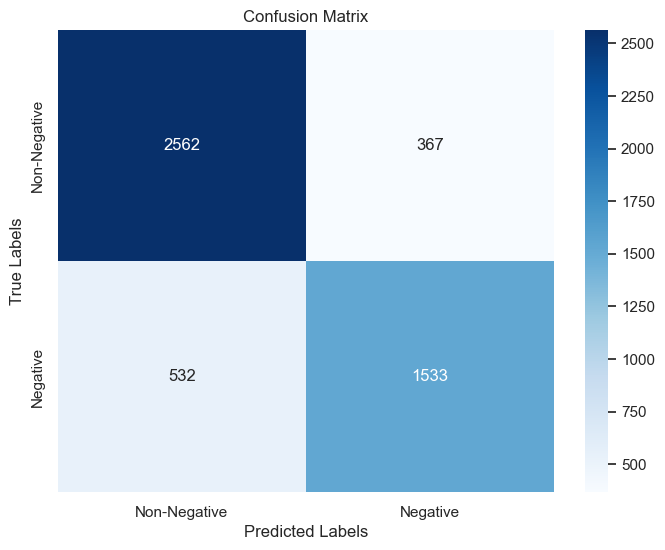

In [37]:
# Assuming `data` is your DataFrame, and it includes 'Text', 'Username', and a binary 'sentiment' column

# Vectorize the Text
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as necessary
tfidf_features = tfidf_vectorizer.fit_transform(data['Text'])

# Encode the Username
label_encoder = LabelEncoder()
username_encoded = label_encoder.fit_transform(data['Username']).reshape(-1, 1)
username_sparse = csr_matrix(username_encoded)

# Combine the TF-IDF features with the encoded Username
combined_features = hstack([tfidf_features, username_sparse])

# Prepare the target variable
y = data['sentiment'].apply(lambda x: 1 if x == 'negative' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

# Initialize and train the Linear SVC model
linear_svc = LinearSVC(random_state=42, dual=False, max_iter=10000)
linear_svc.fit(X_train, y_train)

# Predict on the testing set
y_pred = linear_svc.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))  # Set the figure size as you like
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Negative', 'Negative'])  # Adjust labels as needed
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Negative', 'Negative'])  # Adjust labels as needed
plt.show()


## A visual representation of the accuracy of all the 3 models

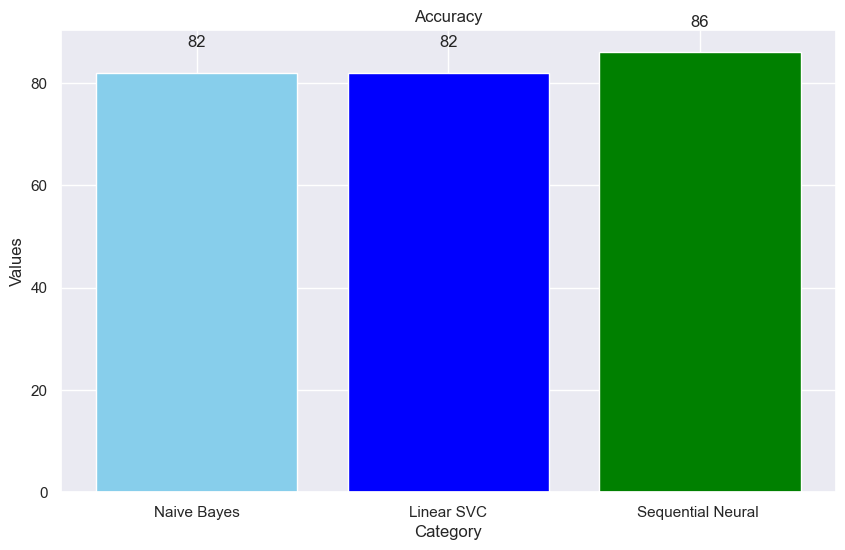

In [44]:

# Sample data: Replace these with your actual data
categories = ['Naive Bayes', 'Linear SVC', 'Sequential Neural ']  # Category names
values = [82,82,86]  # Corresponding values for each category
colors = ['red', 'blue', '']

# Creating the bar chart
plt.figure(figsize=(10, 6))  # Set the figure size as desired
plt.bar(categories, values, color=colors)  # You can customize the color

# Adding title and labels
plt.title('Accuracy')
plt.xlabel('Category')
plt.ylabel('Values')

# Optional: Adding value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 5, str(value), ha='center')  # Adjust positioning as needed

# Show the plot
plt.show()